In [1]:
import pygad.kerasga
import pygad
from pygad.kerasga import KerasGA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import tensorflow 
import time
from IPython.display import display, clear_output, HTML
import os

In [2]:
FILE_NAME = "braess"

MEMORY_SIZE = 3 # can remember last memory_size rounds
NUM_ROUNDS = MEMORY_SIZE
NUM_SOLUTION = 50

NUM_GENERATIONS = 300 # Number of generations.
NUM_PARENTS_MATING = 5 # Number of solutions to be selected as parents in the mating pool.

NUM_ACTIVATION_THRESHOLD = 0.6

HIGHWAY_MULTIPLIER = 1
COUNTRY_ROADS = 10

fit_history = []

# memory array holds memory of all instances
g_memory_array = np.zeros(shape=(MEMORY_SIZE, 4)) + 1
g_buffer_memory_array = np.zeros(shape=(MEMORY_SIZE, 4)) + 1

In [3]:
#############################
#          OPTIONS          #
# 0. Go over the top        #
# 1. Go the lower route     #
# 2. Start top then switch  #
# 3. Start low then switch  #
#############################

In [4]:
model = tensorflow.keras.Sequential([
    tensorflow.keras.Input(shape=(g_memory_array.shape[0], g_memory_array.shape[1], 1)),
    tensorflow.keras.layers.Conv2D(filters=2, kernel_size=2, strides=2, activation='relu'),
    #tensorflow.keras.layers.MaxPool2D(),
    tensorflow.keras.layers.Flatten(),
    tensorflow.keras.layers.Dense(10, activation="relu"),
    tensorflow.keras.layers.Dense(10, activation="sigmoid"),
    tensorflow.keras.layers.Dense(4, activation="sigmoid")
])
model.summary()
keras_ga = KerasGA(model=model, num_solutions=NUM_SOLUTION)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1, 2, 2)        │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214 (856.00 B)

 Trainable params: 214 (856.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
def get_route(prediction):
    return np.argmax(prediction)

def generate_loading_bar(progress, total=30):
    filled_length = int(total * progress)
    bar = '#' * filled_length + ' ' * (total - filled_length)
    return f"[{bar}] {progress * 100:.1f}%"


In [6]:
all_taken_routes = np.zeros(shape=(NUM_GENERATIONS + 1, NUM_ROUNDS, NUM_SOLUTION), dtype=int)
fit = np.zeros(shape=(NUM_SOLUTION))
t_array = []

display_handle = display(HTML("Starting..."), display_id=True)

def do_the_thing(ga_instance):
    if do_the_thing.gen == ga_instance.generations_completed:
        return
    do_the_thing.gen += 1

    global all_taken_routes, g_memory_array, t_array, display_handle, fit

    fit = np.zeros(shape=(NUM_SOLUTION))
    for round in range(NUM_ROUNDS):
        t_start = time.time()

        # 1 for up and 0 for down
        route = []
        for i, sol in enumerate(ga_instance.population):
            raw_prediction = pygad.kerasga.predict(model, sol, g_memory_array.reshape(1, MEMORY_SIZE, 4, 1))
            all_taken_routes[ga_instance.generations_completed, round, i] = get_route(raw_prediction[0])
        
        distribution = np.bincount(all_taken_routes[ga_instance.generations_completed, round], minlength=4)
        g_memory_array = np.append(g_memory_array, distribution).reshape((MEMORY_SIZE + 1, 4))[1:]

        print(distribution)

        for i in range(len(ga_instance.population)):
            r = all_taken_routes[ga_instance.generations_completed, round, i]
            if r == 0:
                fit[i] -= HIGHWAY_MULTIPLIER * (distribution[0] + distribution[2]) + COUNTRY_ROADS
            elif r == 1:
                fit[i] -= COUNTRY_ROADS + HIGHWAY_MULTIPLIER * (distribution[1] + distribution[2])
            elif r == 2:
                fit[i] -= HIGHWAY_MULTIPLIER * (distribution[0] + distribution[1] + distribution[2])
            else:
                fit[i] -= 2 * COUNTRY_ROADS

        t_end = time.time()
        t_array.append(t_end - t_start)
        clear_output(wait=True)
        display_handle.update(HTML(f"""Currently at <b>Generation {ga_instance.generations_completed}</b> and <b>Round {round}</b><br>
                                        Avg time for rounds {np.mean(t_array):.2f} s<br>
                                        ETA for remaining {NUM_ROUNDS - round} rounds: {np.mean(t_array) * (NUM_ROUNDS - round):.2f} s<br>
                                        ETA for all gens: {np.mean(t_array) * (NUM_ROUNDS * NUM_GENERATIONS - NUM_ROUNDS * (ga_instance.generations_completed - 1) - round)/60:.2f} min<br>
                                        <pre><code>{generate_loading_bar((NUM_ROUNDS * (ga_instance.generations_completed) + round)/(NUM_ROUNDS * (NUM_GENERATIONS + 1)))}</code></pre>"""))
 

do_the_thing.gen = -1

def fitness(ga_instance, solution, sol_idx):
    if sol_idx == None:
        sol_idx = 1
    global g_buffer_memory_array, g_memory_array, fit

    do_the_thing(ga_instance)

    return fit[sol_idx]
        
def on_gen(ga_instance):
    fit_history.append(np.mean(ga_instance.cal_pop_fitness()))

In [7]:
ga_instance = pygad.GA(num_generations=NUM_GENERATIONS,
                       num_parents_mating=NUM_PARENTS_MATING,
                       initial_population=keras_ga.population_weights,
                       mutation_type="adaptive",
                       mutation_probability=[0.2, 0.01],
                       suppress_warnings=True,
                       fitness_func=fitness,
                       on_generation=on_gen)

ga_instance.run()

[ 0  0 24 26]


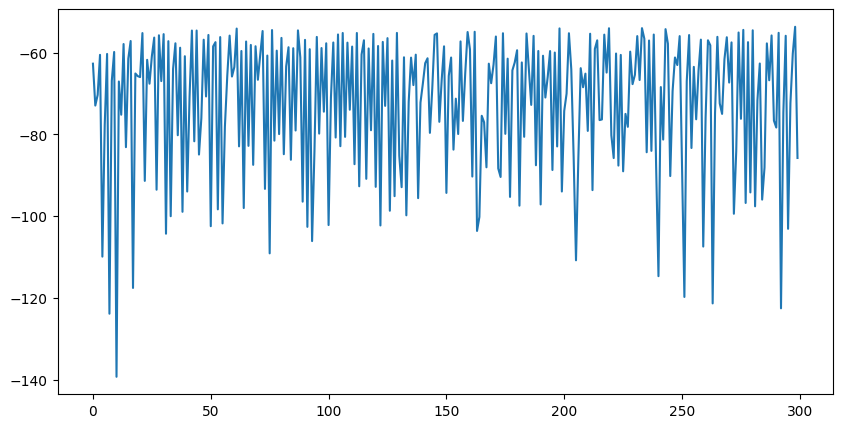

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(fit_history)), fit_history)

In [9]:
times = []
for gen in all_taken_routes:
    time_taken = []
    for round in gen:
        distribution = np.bincount(round, minlength=4)
        temp = 0
        temp += HIGHWAY_MULTIPLIER * (distribution[0] + distribution[2]) + COUNTRY_ROADS
        temp += COUNTRY_ROADS + HIGHWAY_MULTIPLIER * (distribution[1] + distribution[2])
        temp += HIGHWAY_MULTIPLIER * (distribution[0] + distribution[1] + distribution[2])
        temp += 2 * COUNTRY_ROADS
        time_taken.append(temp)
    times.append(np.mean(time_taken))

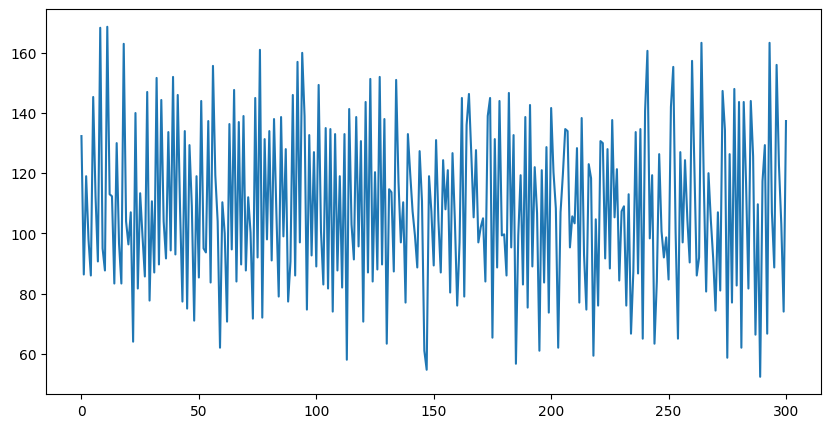

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(times)), times)

In [11]:
save_dir = os.path.join(os.getcwd(), FILE_NAME, f"gen {NUM_GENERATIONS}, rounds {NUM_ROUNDS}, sol {NUM_SOLUTION}")
print(f"Saving at \"{save_dir}\"")
os.makedirs(save_dir, exist_ok=True)
np.savetxt(os.path.join(save_dir + "/routes.txt"), all_taken_routes.reshape((((NUM_GENERATIONS + 1) * NUM_ROUNDS), NUM_SOLUTION)), fmt='%d')
np.savetxt(os.path.join(save_dir + "/fitness.txt"), fit_history)

Saving at "c:\repos\game-theory-and-nn\braess paradox\braess\gen 300, rounds 3, sol 50"


In [16]:
model.save(filepath="test.keras")
ga_instance.save("test")